In [1]:
# =========================================
# 1) Load CSV and detect Likert-scale columns
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata, re

PATH = "survey_results.csv"  # file path

def read_smart(path):
    """
    Attempts to read the CSV file using different encodings and separators
    to handle common variations in exported survey files.
    """
    for enc in ["utf-8", "latin1"]:
        for sep in [";", ",", "\t"]:
            try:
                df = pd.read_csv(path, sep=sep, encoding=enc)
                if df.shape[1] > 1:
                    return df
            except Exception:
                pass
    raise RuntimeError("Could not read the CSV; check the separator and encoding.")

# --- Load raw data ---
df_raw = read_smart(PATH)
df_raw.columns = [c.strip() if isinstance(c, str) else c for c in df_raw.columns]

# --- Detect ONLY Likert-scale columns (values 1..5 in the majority of rows) ---
likert_cols = []
for col in df_raw.columns:
    s = pd.to_numeric(df_raw[col], errors="coerce")
    frac_num = s.notna().mean()
    uniq = set(s.dropna().unique())
    if frac_num >= 0.80 and len(uniq) > 0 and uniq.issubset({1,2,3,4,5}):
        likert_cols.append(col)

if len(likert_cols) < 13:
    print("WARNING: fewer than 13 Likert columns detected:", len(likert_cols))
elif len(likert_cols) > 13:
    print("WARNING: more than 13 Likert columns detected:", len(likert_cols))

# --- DataFrame containing ONLY Likert-scale questions ---
# Columns are renamed P1..P13 in their original order for analysis.
DF = pd.DataFrame({c: pd.to_numeric(df_raw[c], errors="coerce") for c in likert_cols})
codes = [f"P{i+1}" for i in range(DF.shape[1])]
mapa = pd.DataFrame({"Code": codes, "Question": DF.columns})
DF.columns = codes

# --- Save question index mapping (for reference in the paper) ---
mapa.to_csv("question_index_P1_P13.csv", index=False)
print("Saved: question_index_P1_P13.csv")
display(mapa)


Saved: question_index_P1_P13.csv


Code                                           Question
0    P1           I enjoyed participating in the workshop.
1    P2  The workshop was interesting and kept my atten...
2    P3  I felt motivated to actively participate in my...
3    P4  The workshop helped me better understand the c...
4    P5  The practical exercise was more useful than ju...
5    P6  I'd like these types of activities to be inclu...
6    P7  What you learn in this workshop can be applied...
7    P8  Designing synthetic architectures helped me re...
8    P9    The instructions were clear and easy to follow.
9   P10  The support material (cheat sheet and question...
10  P11   The time allocated to the workshop was adequate.
11  P12     Group work helped me learn from my classmates.
12  P13  The exchange of ideas between teams was valuab...

Saved: barras_Section_1._Satisfaction_and_Motivation_mean.eps


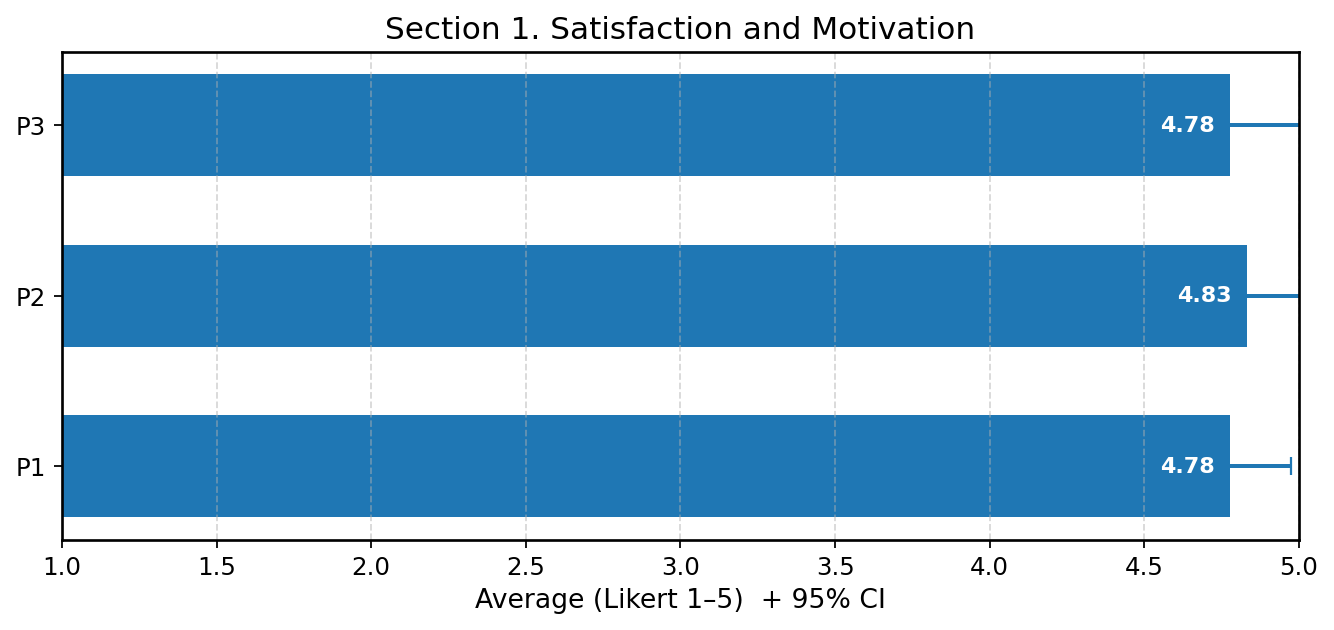

Saved: barras_Section_2._Learning_Usefulness_I_mean.eps


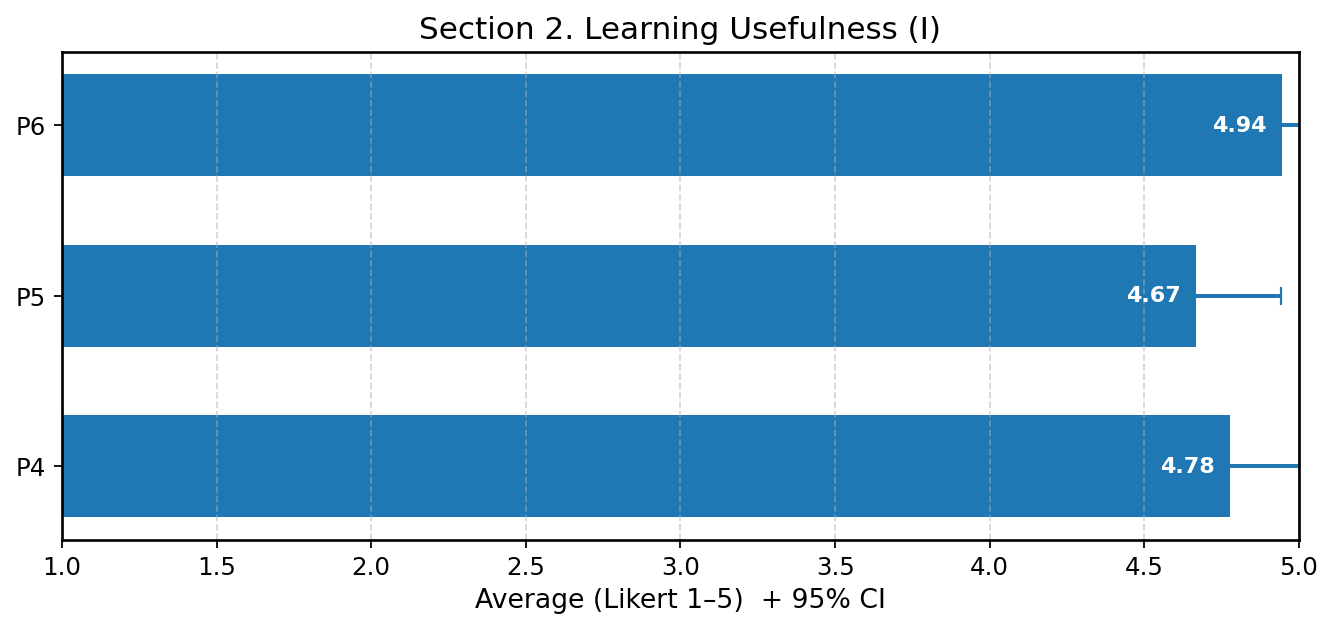

Saved: barras_Section_3._Learning_Usefulness_II_mean.eps


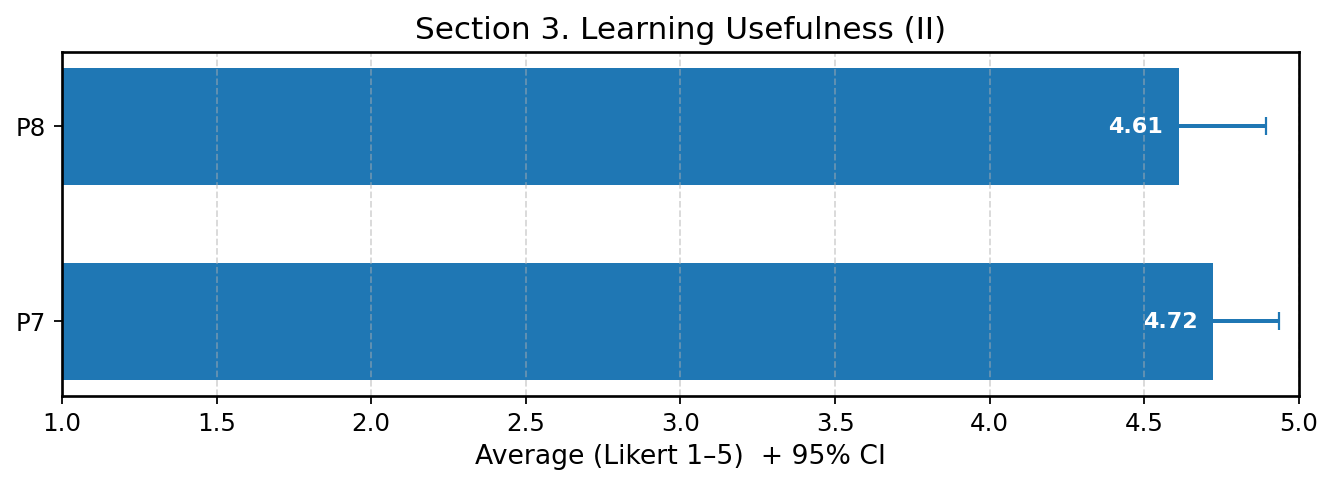

Saved: barras_Section_4._Workshop_Methodology_mean.eps


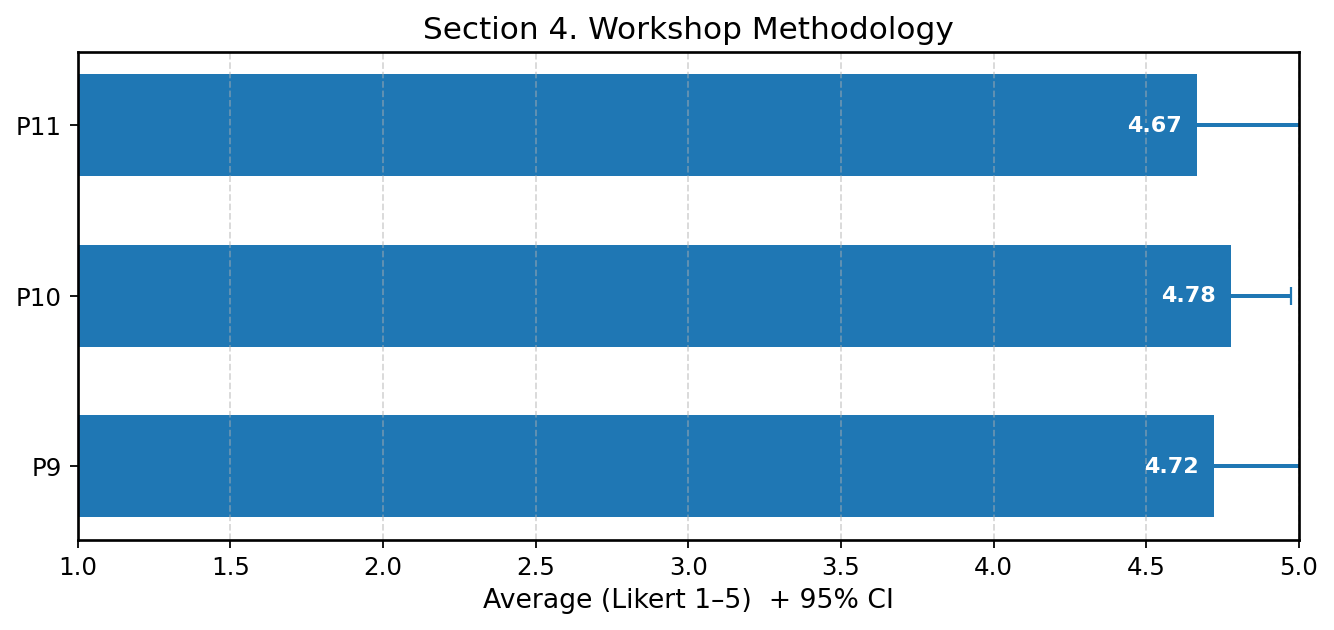

Saved: barras_Section_5._Collaboration_and_Discussion_mean.eps


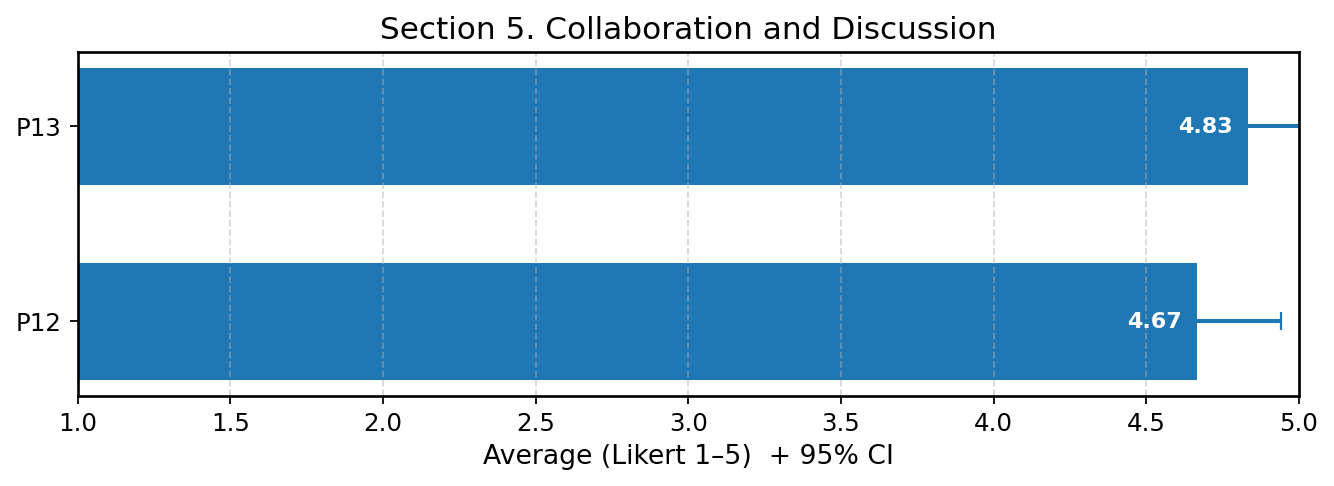

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import unicodedata, re

# --- Clean style configuration ---
mpl.rcParams.update({
    "figure.dpi": 160,
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# --- Likert question groups by thematic section ---
sections = {
    "Section 1. Satisfaction and Motivation": ["P1","P2","P3"],
    "Section 2. Learning Usefulness (I)": ["P4","P5","P6"],
    "Section 3. Learning Usefulness (II)": ["P7","P8"],
    "Section 4. Workshop Methodology": ["P9","P10","P11"],
    "Section 5. Collaboration and Discussion": ["P12","P13"],
}

def _sanitize(s: str) -> str:
    """Sanitize a string to create safe filenames (ASCII, no spaces)."""
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    return re.sub(r"[^A-Za-z0-9._ -]+", "", s).replace(" ", "_")

# ---------- Basic statistics helpers ----------

def _stats_mean_ci95(x: np.ndarray):
    """Compute mean and 95% confidence interval (CI)."""
    x = x[~np.isnan(x)]
    n = x.size
    if n == 0:
        return np.nan, 0.0
    m = x.mean()
    if n == 1:
        return m, 0.0
    sd = x.std(ddof=1)
    ci = 1.96 * sd / np.sqrt(n)   # 95% CI
    return m, ci

def _stats_mean_sd(x: np.ndarray):
    """Compute mean and standard deviation (SD)."""
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan, 0.0
    return x.mean(), x.std(ddof=1) if x.size > 1 else 0.0

def _stats_median_iqr(x: np.ndarray):
    """Compute median and interquartile range (IQR)."""
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan, 0.0, 0.0
    med = np.median(x)
    q1  = np.percentile(x, 25, method="nearest")
    q3  = np.percentile(x, 75, method="nearest")
    lower = med - q1
    upper = q3 - med
    return med, lower, upper

# ---------- Horizontal bar plot by section ----------

def barras_seccion(
    DF: pd.DataFrame,
    sec_name: str,
    codes: list,
    modo: str = "mean",     # "mean" or "median"
    error: str = "ci95",    # if modo="mean": "ci95" or "sd"
    save_eps: bool = True
):
    """
    Plot horizontal bar charts for Likert-scale items in a section.
    - modo="mean": plot mean ± CI95 or ± SD
    - modo="median": plot median ± IQR
    """
    # Prepare data
    codes = [c for c in codes if c in DF.columns]
    vals  = [DF[c].to_numpy(dtype=float) for c in codes]

    y = np.arange(len(codes))
    H = 0.9 * len(codes) + 1.4
    fig, ax = plt.subplots(figsize=(8.5, H))

    if modo == "mean":
        centers, err_low, err_up = [], [], []
        for v in vals:
            if error == "sd":
                m, e = _stats_mean_sd(v); err_low.append(e); err_up.append(e)
            else:
                m, e = _stats_mean_ci95(v); err_low.append(e); err_up.append(e)
            centers.append(m)
        centers = np.array(centers)
        ax.barh(y, centers, height=0.6)
        ax.errorbar(centers, y, xerr=[err_low, err_up],
                    fmt='none', linewidth=1.8, capsize=4)
        ax.set_xlabel("Average (Likert 1–5)" + ("  + 95% CI" if error != "sd" else "  + SD"))
    else:
        centers, low, up = [], [], []
        for v in vals:
            med, l, u = _stats_median_iqr(v)
            centers.append(med); low.append(l); up.append(u)
        centers = np.array(centers)
        ax.barh(y, centers, height=0.6)
        ax.errorbar(centers, y, xerr=[low, up],
                    fmt='none', linewidth=1.8, capsize=4)
        ax.set_xlabel("Median (Likert 1–5)  +  IQR")

    # Labels and formatting
    for yi, c, v in zip(y, codes, centers):
        xpos = v - 0.05 if v > 1.3 else v + 0.05
        halign = "right" if v > 1.3 else "left"
        ax.text(xpos, yi, f"{v:.2f}",
                va="center", ha=halign,
                color="white" if v > 2.0 else "black",
                fontweight="bold", fontsize=10)

    ax.set_yticks(y, codes)
    ax.set_xlim(1, 5)
    ax.set_title(sec_name)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    fig.tight_layout()

    if save_eps:
        out = f"barras_{_sanitize(sec_name)}_{modo}.eps"
        fig.savefig(out, format="eps", bbox_inches="tight")
        print("Saved:", out)
    plt.show()

# ======= Run for each section (choose mode and error type) =======

# Mean + 95% CI:
for sec, codes in sections.items():
    barras_seccion(DF, sec, codes, modo="mean", error="ci95", save_eps=True)

# (Optional) Mean + SD:
# for sec, codes in sections.items():
#     barras_seccion(DF, sec, codes, modo="mean", error="sd", save_eps=True)

# (Optional) Median + IQR:
# for sec, codes in sections.items():
#     barras_seccion(DF, sec, codes, modo="median", save_eps=True)
